Here we will learn how to calculate the areal extent of marsh inundation during a regular tidal cycle on Great Meadows Marsh, Connecticut. This method can be applied to any marsh with a digital elevation model (DEM) of any resolution and a raster delineation of the wetland boundaries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import label, binary_dilation
from scipy.spatial import cKDTree
import xarray as xr
import rioxarray as rxr
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Add file paths

# Connecticut lidar Digital Elevation Model (DEM) in Great Meadows Marsh, 1 m spatial resolution, UTM 18N
dem_file_path = '/Users/opticslab/Documents/LIS_CMS/LIS_CMS_MARSH_TIDES/lidar_DEM/ct_lidar_dem_great_meadows_merged_utm_18n_v2_to_meters.tif'



Note that the DEM is in the UTM 18N coordinate space, we'll want to reproject this into something with lat/lon coordinates for masking later on.

In [3]:
# Load and process DEM and wetland datasets

# Reproject DEM from UTM 18N to EPSG:4326
ds_dem = rxr.open_rasterio(dem_file_path, masked=True).rio.reproject("EPSG:4326")



Quickly, let's address a subtle detail. According to the Connecticut DEM survey (https://maps.cteco.uconn.edu/projects/highres_marsh/), the LiDAR scans taken on August 18, 2021 were taken during high tide.

The survey was conducted by Whiteout Solutions (https://whiteoutsolutions.com/topobathy-lidar/), who use a topobathymetric liDAR system that penetrates up to 15 m below the water surface and 2.5x below secchi depth.

This means that although the tide was high, we can resolve the morphology of the marsh up to 2.5x below the secchi depth, which for this case we will assume is the low tide water level.

These values are stored as negatives in the raster, so we will scale our data by the minimum value in the dataset and reset the reference in the DEM to be low tide.

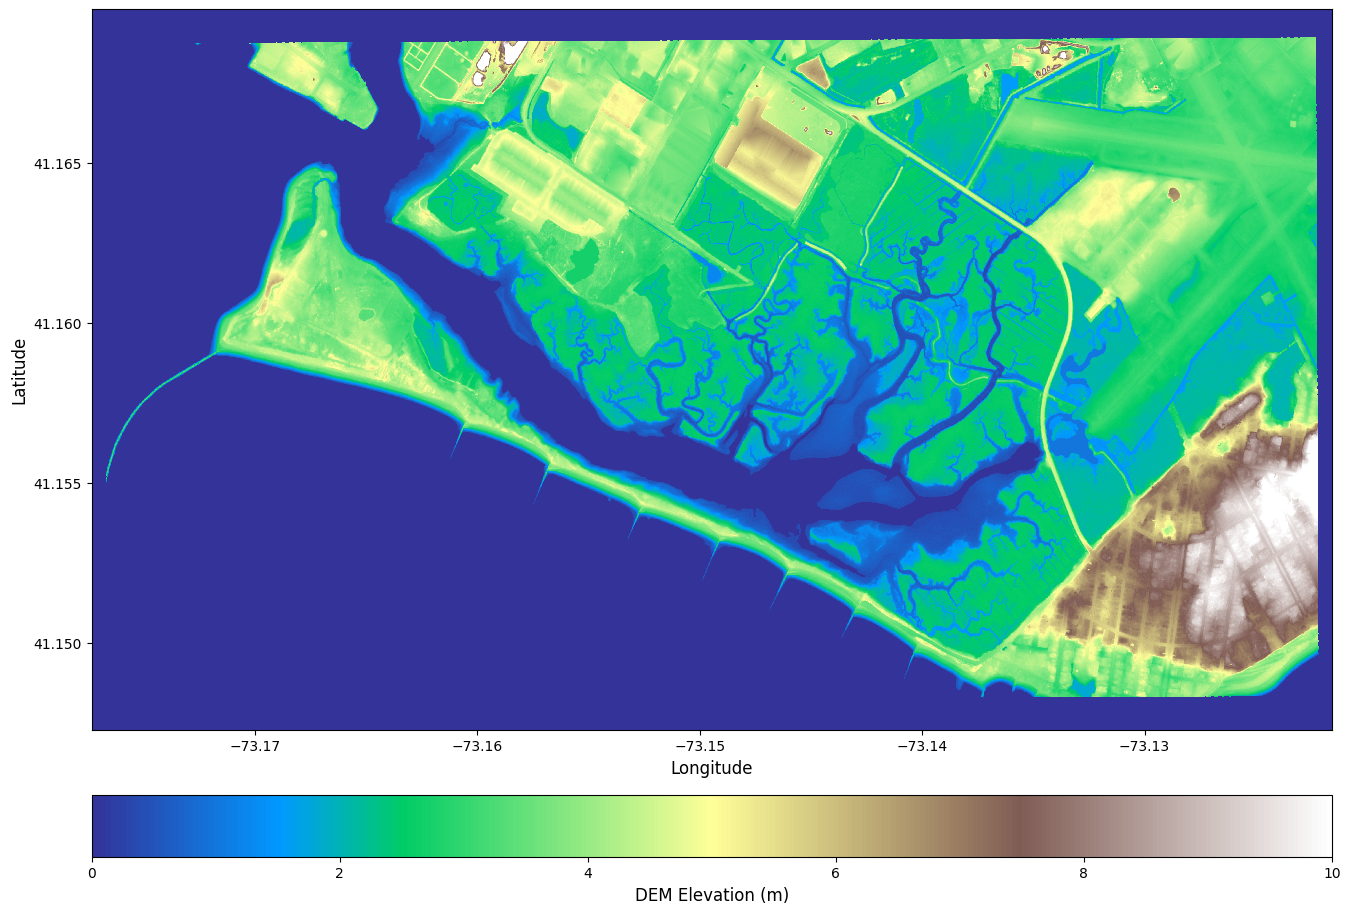

In [4]:
fig, ax = plt.subplots(figsize=(16, 12))

# Scale DEM data by lowest value to retrieve topography below high water line
scaled_dem = ds_dem.copy()
scaled_dem[0] = scaled_dem[0] + 1.5

scaled_dem = scaled_dem.where(scaled_dem >= 0, 0)

# Plot the scaled DEM 
im_dem = ax.pcolormesh(ds_dem.x, ds_dem.y, scaled_dem[0], 
                        cmap='terrain',
                        vmin=0,
                        vmax=10)

# Add some labels
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Add colorbar
cbar = plt.colorbar(im_dem, ax=ax, orientation='horizontal', pad=0.07)
cbar.set_label('DEM Elevation (m)', fontsize=12)

plt.show()

Ultimately, we want to understand changes within the wetland area, but this DEM contains quite a bit of coastline facing Bridgeport Harbor and Long Island Sound that we don't want to include in our analysis. Let's Take a look at the wetland delineation provided by the National Wetlands Inventory (https://fwsprimary.wim.usgs.gov/wetlands/apps/wetlands-mapper/)

The ESRI shapefile file below was selected from a massive watershed (HU8 wetland) dataset in QGIS, this version including Great Meadows Marsh only is available in this repository.


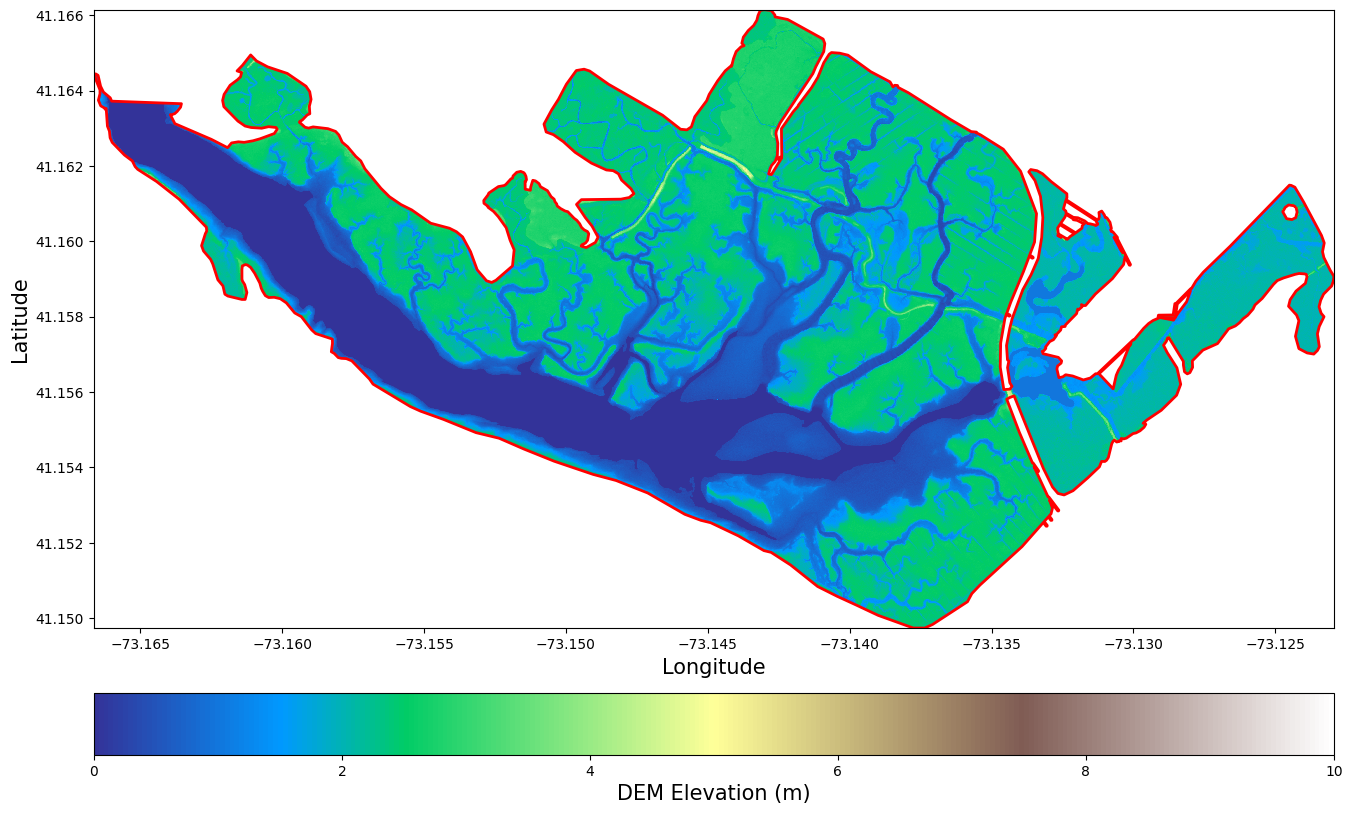

In [5]:

import geopandas as gpd


# Read shapefile (already in EPSG:4326)
shapefile = gpd.read_file('/Users/opticslab/Documents/LIS_CMS/LIS_CMS_MARSH_TIDES/lidar_DEM/GMM_EPSG4326_V2.shp')


# Clip the DEM using rioxarray 
scaled_dem_cropped = scaled_dem.rio.clip(shapefile.geometry, shapefile.crs)


fig, ax = plt.subplots(figsize=(16, 12))



# Plot the scaled DEM 
im_dem = ax.pcolormesh(scaled_dem_cropped.x, scaled_dem_cropped.y, scaled_dem_cropped[0], 
                        cmap='terrain',
                        vmin=0,
                        vmax=10)

# Add some labels
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)

# Add colorbar
cbar = plt.colorbar(im_dem, ax=ax, orientation='horizontal', pad=0.07)
cbar.set_label('DEM Elevation (m)', fontsize=15)


# Plot wetland mask contour
shapefile.boundary.plot(ax=ax, color='red', linewidth=2, label='Marsh Boundary')


plt.show()

Great! Now we have a dataset only inclusive of the marsh as bounded by the National Wetlands Inventory shapefile, so any further analysis will be representative of area in the marsh rather than nearby coastlines. Now comes the fun stuff.

We want to simulate the tide coming in an inundating the low lying portions of the marsh in order to approcimate the inundated area as a function of water height above mean low low water (MLLW) as determined by the NOAA tide gauge in Bridgeport Harbor (https://tidesandcurrents.noaa.gov/waterlevels.html?id=8467150&units=metric&bdate=20210818&edate=20210818&timezone=GMT&datum=MLLW&interval=6&action=).

We do this using binary dilation (https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_dilation.html)

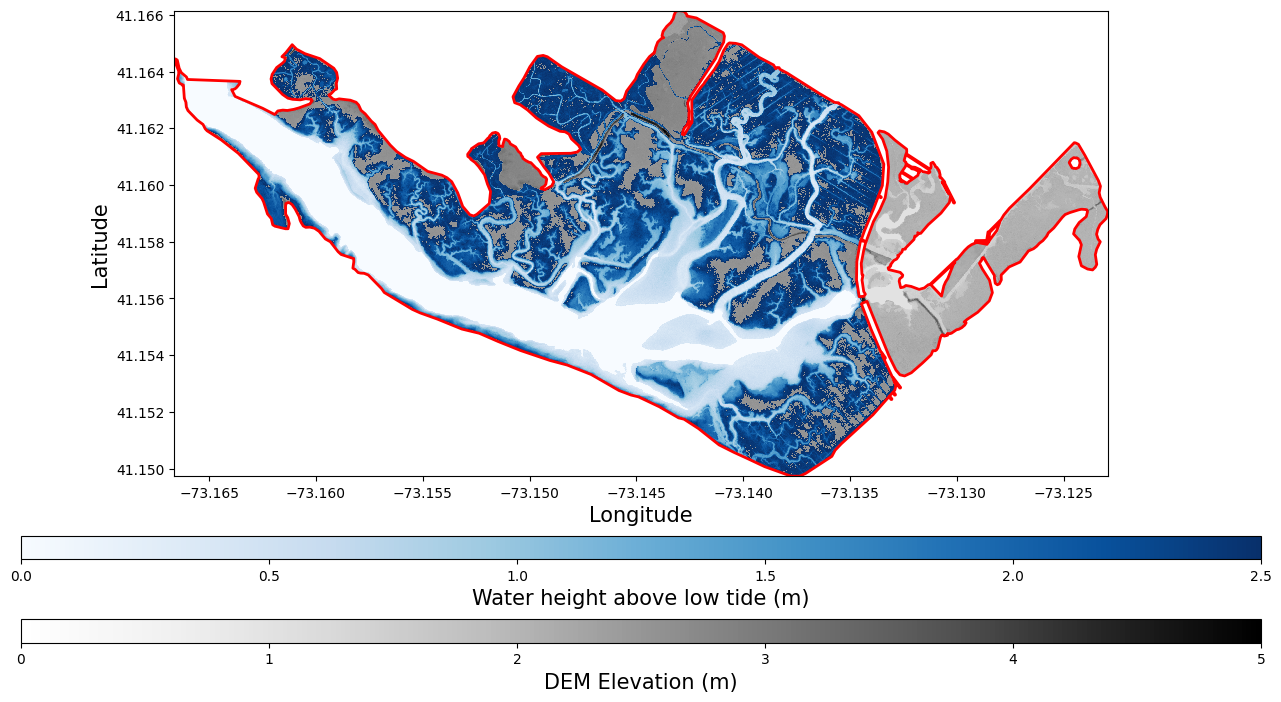

In [6]:
# def simulate_tidal_flood_from_point(dem, water_level, entry_x, entry_y):
#     """Simulate tidal flooding starting from a specific coordinate point"""
#     # Find the nearest grid cell to the specified coordinates
#     x_coords = dem.x.values
#     y_coords = dem.y.values
    
#     # Find closest indices
#     x_idx = np.argmin(np.abs(x_coords - entry_x))
#     y_idx = np.argmin(np.abs(y_coords - entry_y))
    
#     # Initialize water at the entry point
#     flooded = xr.zeros_like(dem, dtype=bool)
#     flooded.values[y_idx, x_idx] = True
    
#     can_flood = dem <= water_level
    
#     changed = True
#     while changed:
#         neighbors = binary_dilation(flooded.values, structure=np.ones((3,3))) & ~flooded.values
#         new_flood = neighbors & can_flood.values
        
#         if not np.any(new_flood):
#             changed = False
#         else:
#             flooded.values = flooded.values | new_flood
    
#     return flooded


def simulate_tidal_flood(dem, water_level):
    """Simulate tidal flooding using iterative flood fill"""
    current_water = dem == np.nanmin(dem)
    flooded = current_water.copy()
    can_flood = dem <= water_level
    
    changed = True
    while changed:
        neighbors = binary_dilation(flooded.values, structure=np.ones((3,3))) & ~flooded.values
        new_flood = neighbors & can_flood.values
        
        if not np.any(new_flood):
            changed = False
        else:
            flooded.values = flooded.values | new_flood
    
    return flooded


# We'll use a tidal range of 2 m, this is realistic for great meadows marsh. 
# See the link to the Bridgeport Harbor NOAA tide gauge above
tide_level = 2.5
entry_lat = 41.163480
entry_lon = -73.165062
#flooded_areas_map_point = simulate_tidal_flood_from_point(scaled_dem_cropped[0], tide_level, entry_lon, entry_lat)
flooded_areas_map = simulate_tidal_flood(scaled_dem_cropped[0], tide_level)

new_inundation = flooded_areas_map
tidal_inundation = scaled_dem_cropped[0].where(new_inundation)

#new_inundation_point = flooded_areas_map_point
#tidal_inundation_point = scaled_dem_cropped[0].where(new_inundation_point)


fig, ax = plt.subplots(figsize=(16, 12))

im_dem = ax.pcolormesh(scaled_dem_cropped.x, scaled_dem_cropped.y, scaled_dem_cropped[0], 
                        cmap='Greys',
                        vmin=0,
                        vmax=5)


# Plot seasonal tidal inundation areas
tidal_plot = ax.pcolormesh(tidal_inundation.x, tidal_inundation.y, tidal_inundation,
                            cmap='Blues',
                            vmin=0,
                            vmax=tide_level)

# # Plot seasonal tidal inundation areas
# tidal_plot = ax.pcolormesh(tidal_inundation_point.x, tidal_inundation_point.y, tidal_inundation_point,
#                             cmap='Reds',
#                             vmin=0,
#                             vmax=tide_level)


# Plot wetland mask contour
shapefile.boundary.plot(ax=ax, color='red', linewidth=2, label='Marsh Boundary')


# Add some labels
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)

# Add colorbars to the map
divider = make_axes_locatable(ax)
cbar_ax1 = divider.append_axes("bottom", size="5%", pad=0.6)
cbar_ax2 = divider.append_axes("bottom", size="5%", pad=0.6)

cbar1 = plt.colorbar(tidal_plot, cax=cbar_ax1, orientation='horizontal')
cbar1.set_label('Water height above low tide (m)', fontsize=15)

cbar2 = plt.colorbar(im_dem, cax=cbar_ax2, orientation='horizontal')
cbar2.set_label('DEM Elevation (m)', fontsize=15)

plt.show()


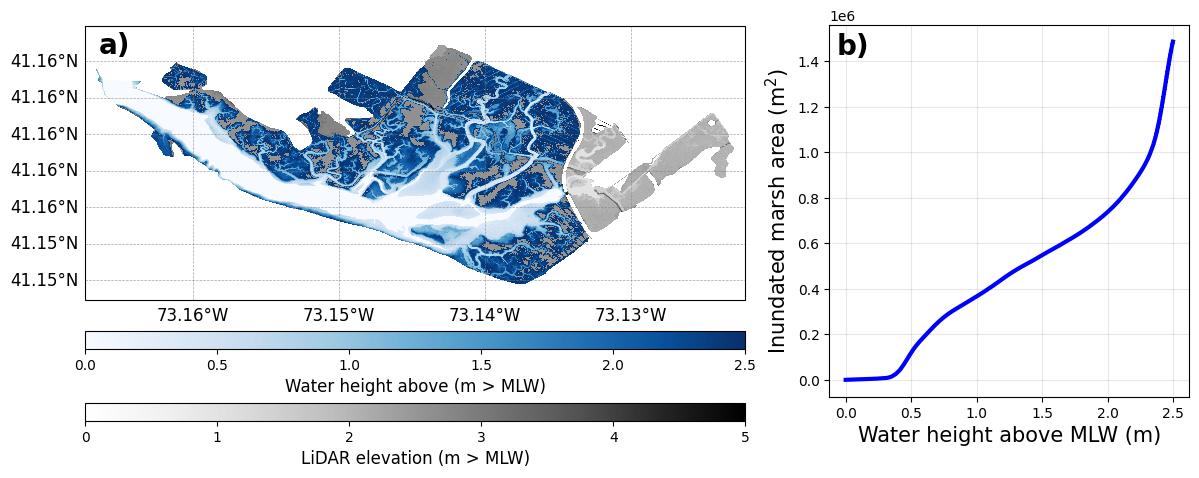

In [37]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

# Calculate inundation curve data

water_levels = np.linspace(0, 2.5, 10000)
flooded_pixels = np.array([np.sum(tidal_inundation < t) for t in water_levels])

# Convert pixels to area (assuming square meters)
pixel_area = 0.371  # Adjust this based on your DEM resolution
flooded_areas = np.array(flooded_pixels) * pixel_area

water_pixels = np.count_nonzero(scaled_dem_cropped[0] == 0)
water_area = water_pixels * pixel_area

flooded_marsh_area = flooded_areas - water_area
flooded_marsh_area[0] = 0

# Create figure with custom positioning
fig = plt.figure(figsize=(12, 6))

# Define custom positions for both subplots [left, bottom, width, height]
ax1_pos = [0.06, 0.04, 0.55, 0.8]  # Map subplot
ax2_pos = [0.68, 0.05, 0.3, 0.62]  # Inundation curve subplot

# Create the map subplot with custom positioning
ax1 = fig.add_axes(ax1_pos, projection=ccrs.PlateCarree())

# Plot on the map
im_dem = ax1.pcolormesh(scaled_dem_cropped.x, scaled_dem_cropped.y, scaled_dem_cropped[0], 
                        cmap='Greys', vmin=0, vmax=5)

marsh_extent = [-73.167347, -73.122155, 41.148673, 41.167437]
ax1.set_extent(marsh_extent, crs=ccrs.PlateCarree())

tidal_plot = ax1.pcolormesh(tidal_inundation.x, tidal_inundation.y, tidal_inundation,
                            cmap='Blues', vmin=0, vmax=tide_level)

gl = ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
gl.xformatter = LongitudeFormatter(number_format='.2f')
gl.yformatter = LatitudeFormatter(number_format='.2f')

# Create the inundation curve subplot with custom positioning
ax2 = fig.add_axes(ax2_pos)
ax2.plot(water_levels, flooded_marsh_area, 'b-', linewidth=3)
ax2.set_xlabel('Water height above MLW (m)', fontsize=15)
ax2.set_ylabel('Inundated marsh area (m$^{2}$)', fontsize=15)
ax2.grid(True, alpha=0.3)

# Manually create colorbar axes
cbar_ax1 = fig.add_axes([0.06, 0.13, 0.55, 0.03])  # [left, bottom, width, height]
cbar_ax2 = fig.add_axes([0.06, 0.01, 0.55, 0.03])

cbar1 = plt.colorbar(tidal_plot, cax=cbar_ax1, orientation='horizontal')
cbar1.set_label('Water height above (m > MLW)', fontsize=12)

cbar2 = plt.colorbar(im_dem, cax=cbar_ax2, orientation='horizontal')
cbar2.set_label('LiDAR elevation (m > MLW)', fontsize=12)


# Add letter a) in top left of ax1
ax1.text(0.02, 0.98, 'a)', transform=ax1.transAxes, fontsize=20, 
         fontweight='bold', va='top', ha='left')

# Add letter b) in top left of ax2
ax2.text(0.02, 0.98, 'b)', transform=ax2.transAxes, fontsize=20, 
         fontweight='bold', va='top', ha='left')

plt.show()

In [209]:
import pickle

area_function = {
    'flooded_marsh_area': flooded_marsh_area,
    'water_levels': water_levels
}

with open('marsh_area_function.pkl', 'wb') as f:  
    pickle.dump(area_function, f)

